Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from sklearn.cluster import KMeans
from mlxtend.frequent_patterns import apriori, association_rules

Getting the data

In [ ]:
df=pd.read_excel('Online Retail.xlsx')

#Data Exploration

In [ ]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [ ]:
df.tail()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France


In [ ]:
df.shape

(541909, 8)

In [ ]:
print(df.dtypes)

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object


In [ ]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


The above cell shows that the 'Quantity' and 'UnitPrice' columns have negative values

In [ ]:
def descr(df):
  no_rows=df.shape[0]
  types=df.dtypes
  counts=df.apply(lambda x: x.count())
  uniques=df.apply(lambda x: x.unique())
  nulls=df.apply(lambda x: x.isnull().sum())
  distincts=df.apply(lambda x: x.unique().shape[0])
  nan_percent=(df.isnull().sum()/no_rows)*100
  skewness=df.skew()
  kurtosis=df.kurt()

  cols={'dtypes':types, 'counts':counts, 'distincts':distincts, 'nulls':nulls,  
        'missing_percent':nan_percent, 'uniques':uniques, 'skewness':skewness, 'kurtosis':kurtosis}
  table=pd.DataFrame(data=cols)
  return table

details = descr(df)
display(details.sort_values(by='missing_percent', ascending=False))

,dtypes,counts,distincts,nulls,missing_percent,uniques,skewness,kurtosis
CustomerID,float64,406829,4373,135080,24.926694,"[17850.0, 13047.0, 12583.0, 13748.0, 15100.0, ...",0.029835,-1.179982
Description,object,540455,4224,1454,0.268311,"[WHITE HANGING HEART T-LIGHT HOLDER, WHITE MET...",NaN,NaN
Country,object,541909,38,0,0.000000,"[United Kingdom, France, Australia, Netherland...",NaN,NaN
InvoiceDate,datetime64[ns],541909,23260,0,0.000000,"[2010-12-01T08:26:00.000000000, 2010-12-01T08:...",NaN,NaN
InvoiceNo,object,541909,25900,0,0.000000,"[536365, 536366, 536367, 536368, 536369, 53637...",NaN,NaN
Quantity,int64,541909,722,0,0.000000,"[6, 8, 2, 32, 3, 4, 24, 12, 48, 18, 20, 36, 80...",-0.264076,119769.160031
StockCode,object,541909,4070,0,0.000000,"[85123A, 71053, 84406B, 84029G, 84029E, 22752,...",NaN,NaN
UnitPrice,float64,541909,1630,0,0.000000,"[2.55, 3.39, 2.75, 7.65, 4.25, 1.85, 1.69, 2.1...",186.506972,59005.719097


From here we can see that 'CustomerID' and 'Description' columns have NaN values.

#**Data Cleaning**

Finding out where all the negative and values are present

In [1]:
print("Number of rows where negative values are present : ", 
      df[(df['Quantity']<0) | (df['UnitPrice']<0)].shape[0])

print("\nAre negative values in both Quantity and UnitPrice present in same row : ", end="")
if df[(df['Quantity']<0) & (df['UnitPrice']<0)].shape[0]==0:
  print("No")
else:
  print("Yes")

print("\nAre negative or 0 values in both Quantity and UnitPrice present in same row : ", end="")
if df[(df['Quantity']<=0) & (df['UnitPrice']<=0)].shape[0]==0:
  print("No")
else:
  print("Yes")

print("What is the customer ID of such rows :",
      df.loc[(df.Quantity<=0) & (df.UnitPrice<=0), ['CustomerID']].CustomerID.unique())

NameError: ignored

In [ ]:
print("Invoice Numbers of rows with quantity having negative values : ") 
print(df.loc[(df.Quantity<0) & ~(df.CustomerID.isnull()), 'InvoiceNo'])
print("\nAll the Invoice Numbers start with : ", df.loc[(df.Quantity<0) & ~(df.CustomerID.isnull()), 'InvoiceNo'].apply(lambda x: x[0]).unique())

Invoice Numbers of rows with quantity having negative values : 
141       C536379
154       C536383
235       C536391
236       C536391
237       C536391
           ...   
540449    C581490
541541    C581499
541715    C581568
541716    C581569
541717    C581569
Name: InvoiceNo, Length: 8905, dtype: object

All the Invoice Numbers start with :  ['C']


In [ ]:
print("Invoice Numbers of rows with UnitPrice having negative values : ") 
display(df[(df.UnitPrice<0) & (df.CustomerID.isnull())])
print("\nAll the Invoice Numbers start with : ", df.loc[(df.UnitPrice<0) & (df.CustomerID.isnull()), 'InvoiceNo'].apply(lambda x: x[0]).unique())

print("\nInvoice Numbers of rows with UnitPrice having 0 values : ") 
display(df[(df.UnitPrice==0) & ~(df.CustomerID.isnull())].head(10))
print("Total number of rows : ", df[(df.UnitPrice==0) & ~(df.CustomerID.isnull())].shape[0])
#print("\nAll the Invoice Numbers start with : ", df.loc[(df.UnitPrice==0) & ~(df.CustomerID.isnull()), 'InvoiceNo'].apply(lambda x: x[0]).unique())

Invoice Numbers of rows with UnitPrice having negative values : 


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
299983,A563186,B,Adjust bad debt,1,2011-08-12 14:51:00,-11062.06,NaN,United Kingdom
299984,A563187,B,Adjust bad debt,1,2011-08-12 14:52:00,-11062.06,NaN,United Kingdom



All the Invoice Numbers start with :  ['A']

Invoice Numbers of rows with UnitPrice having 0 values : 


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
9302,537197,22841,ROUND CAKE TIN VINTAGE GREEN,1,2010-12-05 14:02:00,0.0,12647.0,Germany
33576,539263,22580,ADVENT CALENDAR GINGHAM SACK,4,2010-12-16 14:36:00,0.0,16560.0,United Kingdom
40089,539722,22423,REGENCY CAKESTAND 3 TIER,10,2010-12-21 13:45:00,0.0,14911.0,EIRE
47068,540372,22090,PAPER BUNTING RETROSPOT,24,2011-01-06 16:41:00,0.0,13081.0,United Kingdom
47070,540372,22553,PLASTERS IN TIN SKULLS,24,2011-01-06 16:41:00,0.0,13081.0,United Kingdom
56674,541109,22168,ORGANISER WOOD ANTIQUE WHITE,1,2011-01-13 15:10:00,0.0,15107.0,United Kingdom
86789,543599,84535B,FAIRY CAKES NOTEBOOK A6 SIZE,16,2011-02-10 13:08:00,0.0,17560.0,United Kingdom
130188,547417,22062,CERAMIC BOWL WITH LOVE HEART DESIGN,36,2011-03-23 10:25:00,0.0,13239.0,United Kingdom
139453,548318,22055,MINI CAKE STAND HANGING STRAWBERY,5,2011-03-30 12:45:00,0.0,13113.0,United Kingdom
145208,548871,22162,HEART GARLAND RUSTIC PADDED,2,2011-04-04 14:42:00,0.0,14410.0,United Kingdom


Total number of rows :  40


Dropping the rows having negative and null values based on what we found above

In [ ]:
df=df[~(df.CustomerID.isnull())]
df = df[~(df.Quantity<0)]
df = df[df.UnitPrice>0]
df.reset_index()
details = descr(df)
display(details.sort_values(by='distincts', ascending=False))
print(df.shape)

,dtypes,counts,distincts,nulls,missing_percent,uniques,skewness,kurtosis
InvoiceNo,object,397884,18532,0,0.0,"[536365, 536366, 536367, 536368, 536369, 53637...",-0.178524,-1.200748
InvoiceDate,datetime64[ns],397884,17282,0,0.0,"[2010-12-01T08:26:00.000000000, 2010-12-01T08:...",NaN,NaN
CustomerID,float64,397884,4338,0,0.0,"[17850.0, 13047.0, 12583.0, 13748.0, 15100.0, ...",0.025729,-1.180822
Description,object,397884,3877,0,0.0,"[WHITE HANGING HEART T-LIGHT HOLDER, WHITE MET...",NaN,NaN
StockCode,object,397884,3665,0,0.0,"[85123A, 71053, 84406B, 84029G, 84029E, 22752,...",NaN,NaN
UnitPrice,float64,397884,440,0,0.0,"[2.55, 3.39, 2.75, 7.65, 4.25, 1.85, 1.69, 2.1...",204.032727,58140.396673
Quantity,int64,397884,301,0,0.0,"[6, 8, 2, 32, 3, 4, 24, 12, 48, 18, 20, 36, 80...",409.892972,178186.243253
Country,object,397884,37,0,0.0,"[United Kingdom, France, Australia, Netherland...",NaN,NaN


(397884, 8)


Here, we have removed all null and negative values from dataset

In [ ]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,397884.000000,397884.000000,397884.000000
mean,12.988238,3.116488,15294.423453
std,179.331775,22.097877,1713.141560
min,1.000000,0.001000,12346.000000
25%,2.000000,1.250000,13969.000000
50%,6.000000,1.950000,15159.000000
75%,12.000000,3.750000,16795.000000
max,80995.000000,8142.750000,18287.000000


In [ ]:
dfv=df.copy()                               #making a copy of DataFrame 

Assigning numerical values to all the elements in StockCode

In [ ]:
x=dfv['StockCode'].value_counts()
item_type_mapping={}
item_list=x.index
for i in range(0,len(item_list)):
    item_type_mapping[item_list[i]]=i

dfv['StockCode']=dfv['StockCode'].map(lambda x:item_type_mapping[x]) 



In [ ]:
dfv['amount'] = dfv.Quantity*dfv.UnitPrice
dfv['amount']

0         15.30
1         20.34
2         22.00
3         20.34
4         20.34
          ...  
541904    10.20
541905    12.60
541906    16.60
541907    16.60
541908    14.85
Name: amount, Length: 397884, dtype: float64

#Data Visualization

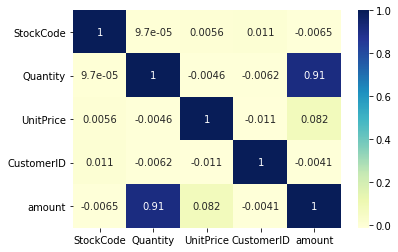

In [ ]:
sns.heatmap(dfv.corr(), cmap="YlGnBu", annot=True)

In [ ]:
#sns.pairplot(dfv)

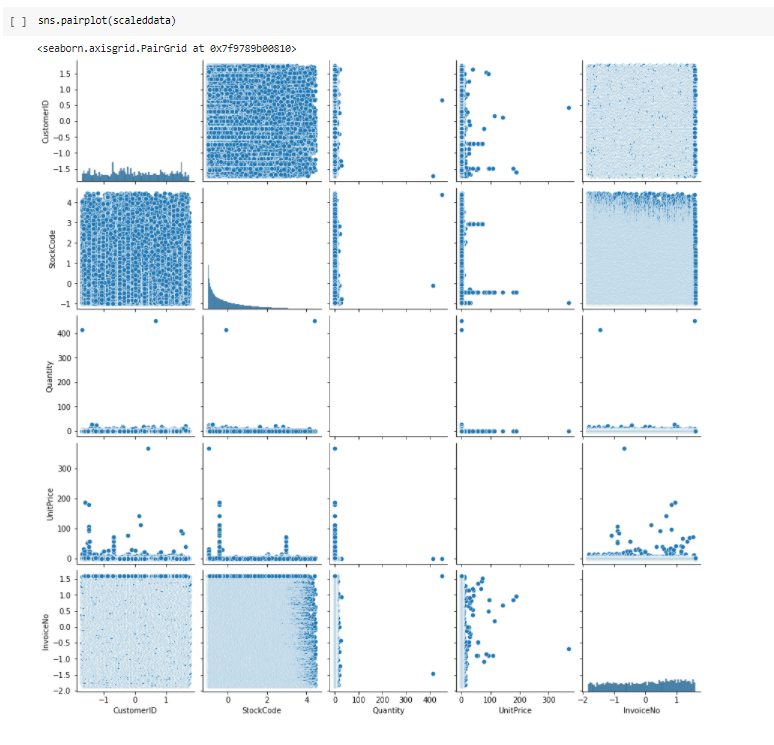

As we can see there are a few outliers in the dataset. These outliers affect the model, so we must remove them to get best results.

In [ ]:
dfv = dfv[~(dfv.Quantity>dfv.Quantity.quantile(0.95))]
dfv = dfv[~(dfv.UnitPrice>dfv.UnitPrice.quantile(0.95))]

In [ ]:
#sns.pairplot(dfv)

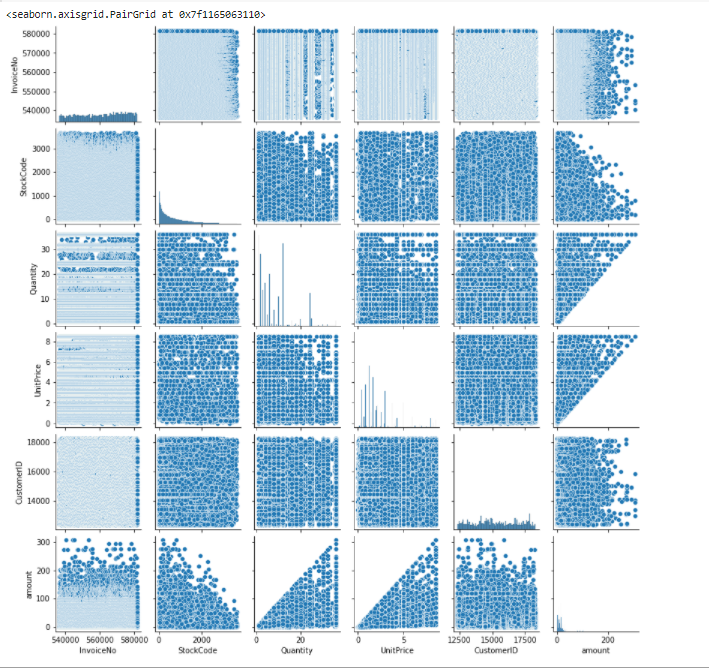

In [ ]:
dfv.describe()

,StockCode,Quantity,UnitPrice,CustomerID,amount
count,361147.000000,361147.000000,361147.000000,361147.000000,361147.000000
mean,657.229923,7.689010,2.462422,15317.936577,13.781492
std,667.820034,7.491245,1.974761,1709.619269,15.557298
min,0.000000,1.000000,0.001000,12347.000000,0.001000
25%,135.000000,2.000000,1.250000,13988.000000,4.160000
50%,429.000000,5.000000,1.690000,15220.000000,10.200000
75%,978.000000,12.000000,2.950000,16814.000000,17.400000
max,3664.000000,36.000000,8.500000,18287.000000,306.000000


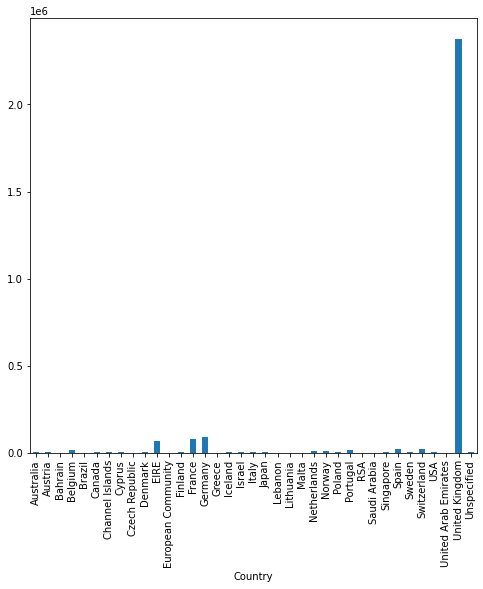

In [ ]:
dfv.groupby('Country')['Quantity'].sum().plot(kind = 'bar', figsize=(8,8))

This shows that compared to UK all other countries have very less sales

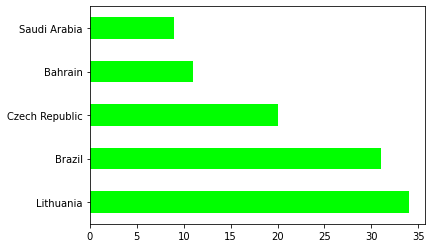

In [ ]:
dfv.Country.value_counts()[-5:].plot(kind='barh',colormap='brg_r')

These are the countries with least sales

In [ ]:
dfv['year'] = dfv['InvoiceDate'].dt.year
dfv['month'] = dfv['InvoiceDate'].dt.month
dfv['hour'] = dfv['InvoiceDate'].dt.hour
dfv['weekday'] = dfv['InvoiceDate'].dt.day_name()

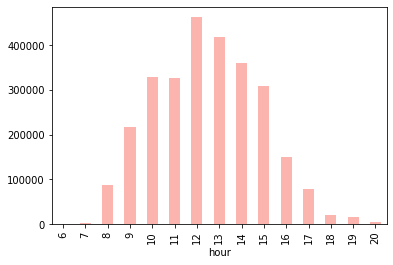

In [ ]:
dfv.groupby('hour')['Quantity'].sum().plot(kind = 'bar', colormap = 'Pastel1')

This plot shows that afternoons are the busiest times

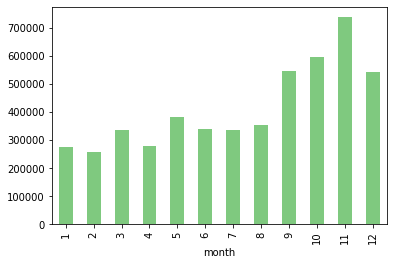

In [ ]:
dfv.groupby('month')['amount'].sum().plot(kind='bar', colormap = 'Accent')

This shows that maximum sales have taken place in the last months

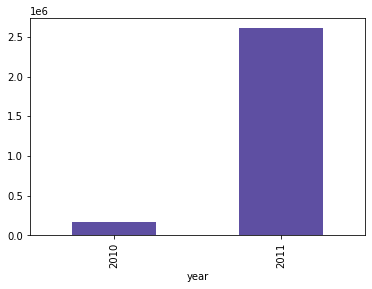

In [ ]:
dfv.groupby('year')['Quantity'].sum().plot(kind='bar',colormap = 'Spectral_r')

In [ ]:
dfv.InvoiceDate.sort_values()

0        2010-12-01 08:26:00
1        2010-12-01 08:26:00
2        2010-12-01 08:26:00
3        2010-12-01 08:26:00
4        2010-12-01 08:26:00
                 ...        
541896   2011-12-09 12:50:00
541895   2011-12-09 12:50:00
541907   2011-12-09 12:50:00
541900   2011-12-09 12:50:00
541908   2011-12-09 12:50:00
Name: InvoiceDate, Length: 361147, dtype: datetime64[ns]

The huge difference between the years is because the dataset starts from december of 2010 and ends in december 2011

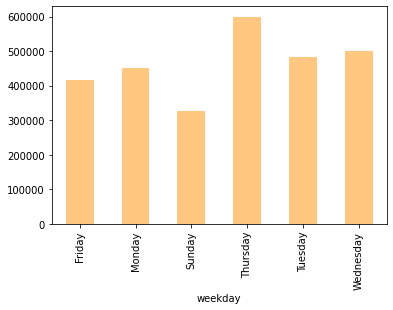

In [ ]:
dfv.groupby('weekday')['Quantity'].sum().plot(kind='bar',colormap = 'copper_r')

Here we can see that no sales happen on Saturday, so the shop must be closed that day and the busiest day is Thursday

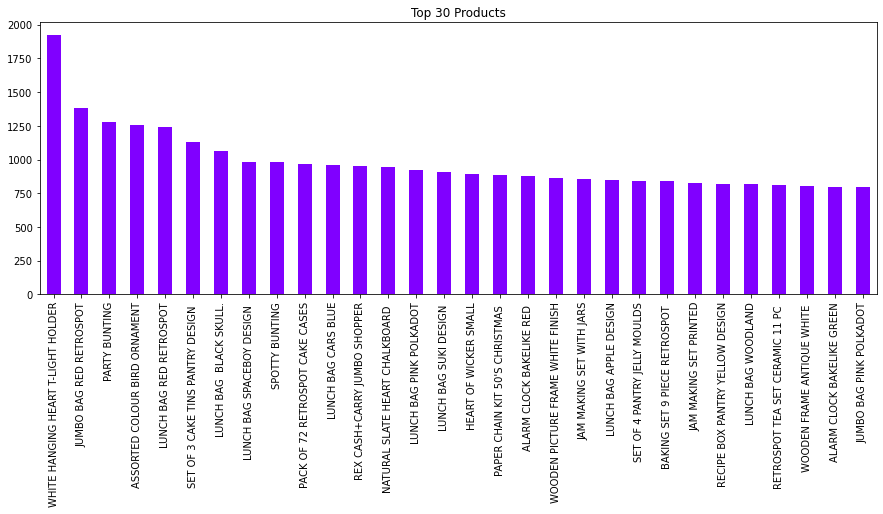

In [ ]:
dfv.Description.value_counts().sort_values(ascending=False)[:30].plot(kind='bar', colormap='rainbow', figsize=(15,5), title="Top 30 Products")

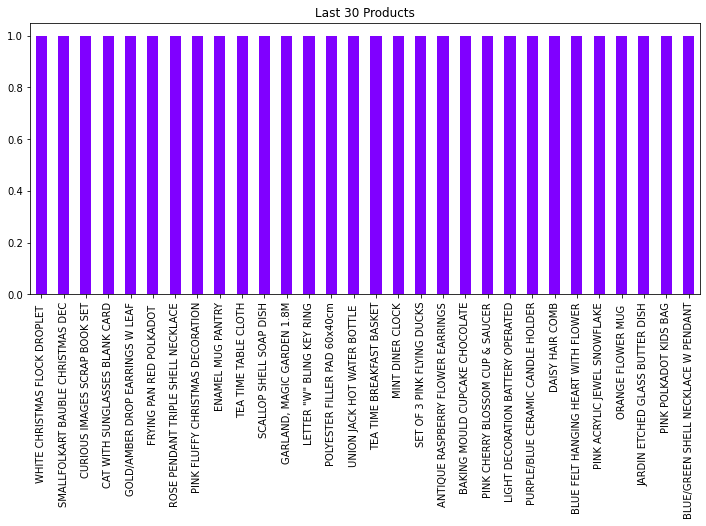

In [ ]:
dfv.Description.value_counts().sort_values(ascending=False)[-30:].plot(kind='bar', colormap='rainbow', figsize=(12,5), title="Last 30 Products")

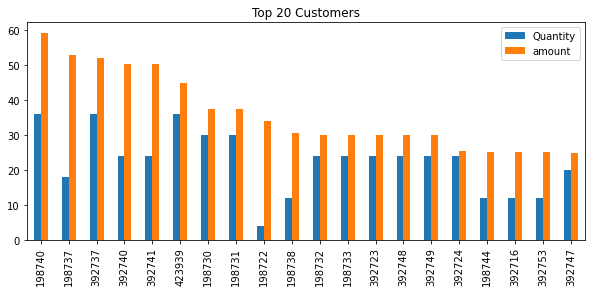

In [ ]:
dfv.sort_values(['CustomerID','amount'], ascending=False).drop(['InvoiceDate','InvoiceNo','StockCode','CustomerID','year','month','hour', 'UnitPrice'], axis=1)[:20].plot(kind='bar', figsize=(10,4), title='Top 20 Customers')

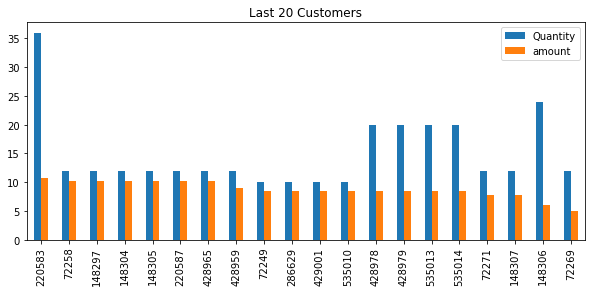

In [ ]:
dfv.sort_values(['CustomerID','amount'], ascending=False).drop(['InvoiceDate','InvoiceNo','StockCode','CustomerID','year','month','hour', 'UnitPrice'], axis=1)[-20:].plot(kind='bar', figsize=(10,4), title='Last 20 Customers')

#**RFM Model**

**RFM Model for Customer Value:**
Due to lack of other data columns, we have used a RFM method, *Recency, Frequency and Monetary Value*. It uses customer behaviour for finding our customer segments. The RFM model will take the transactions of a customer and calculate three important informational attributes about each customer:



**Recency**: Number of days since last purchase


In [ ]:
refrence_date = dfv.InvoiceDate.max() + datetime.timedelta(days = 1)
print('Reference Date:', refrence_date)
dfv['days_since_last_purchase'] = (refrence_date - dfv.InvoiceDate).astype('timedelta64[D]')

customer_history_df =  dfv[['CustomerID', 'days_since_last_purchase']].groupby("CustomerID").min().reset_index()
customer_history_df.rename(columns={'days_since_last_purchase':'recency'}, inplace=True)
customer_history_df.describe().transpose()
customer_history_df.shape


Reference Date: 2011-12-10 12:50:00


(4214, 2)

**Frequency**: Total number of transactions

In [ ]:
customer_freq = (dfv[['CustomerID', 'InvoiceNo']].groupby("CustomerID").count().reset_index())
customer_freq.rename(columns={'InvoiceNo':'frequency'},inplace=True)
customer_history_df = customer_history_df.merge(customer_freq)
customer_history_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
CustomerID,4214.0,15288.899383,1718.660576,12347.0,13809.25,15278.0,16767.75,18287.0
recency,4214.0,92.344091,99.958514,1.0,18.00,51.0,143.00,374.0
frequency,4214.0,85.701709,213.319912,1.0,16.00,39.0,94.00,7579.0



**Monetary value**: The dollar (or pounds in our case) value of all the transactions that the customer made at the establishment

In [ ]:
customer_monetary_val = dfv[['CustomerID', 'amount']].groupby("CustomerID").sum().reset_index()
customer_history_df = customer_history_df.merge(customer_monetary_val)
customer_history_df

,CustomerID,recency,frequency,amount
0,12347.0,2.0,174,3743.43
1,12348.0,249.0,6,90.20
2,12349.0,19.0,66,1287.15
3,12350.0,310.0,16,294.40
4,12352.0,36.0,71,1232.44
...,...,...,...,...
4209,18280.0,278.0,9,160.70
4210,18281.0,181.0,5,46.92
4211,18282.0,8.0,8,113.13
4212,18283.0,4.0,754,2068.98


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb4242e1c10>,
      dtype=object)

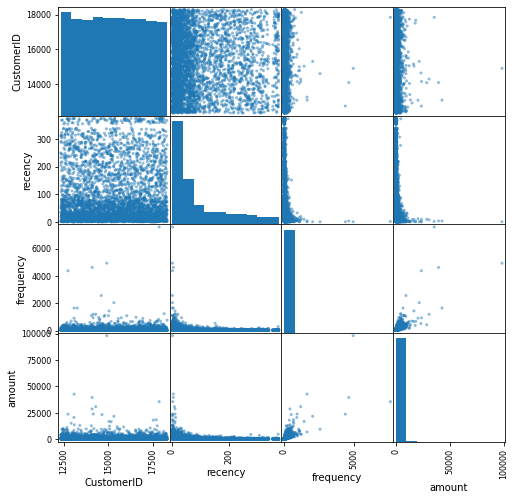

In [ ]:
pd.plotting.scatter_matrix(customer_history_df, alpha=0.5, figsize=(8,8))

In [ ]:
customer_history_df = customer_history_df[~(customer_history_df.amount>customer_history_df.amount.quantile(0.95))]

Normalizing all the values

In [ ]:
scaleddata=dfv.copy()

In [ ]:
scaleddata['StockCode'] = scaleddata['StockCode']  / scaleddata["StockCode"].abs().max()
scaleddata['UnitPrice'] = scaleddata['UnitPrice']  / scaleddata["UnitPrice"].abs().max()
scaleddata['Quantity'] = scaleddata['Quantity']  / scaleddata["Quantity"].abs().max()
#scaleddata['CustomerID'] = scaleddata['CustomerID']  / scaleddata["CustomerID"].abs().max()
scaleddata['amount'] = scaleddata['amount']  / scaleddata["amount"].abs().max()
scaleddata['InvoiceNo'] = scaleddata['InvoiceNo']  / scaleddata["InvoiceNo"].abs().max()

In [ ]:
customer_history_df['recency'] = customer_history_df['recency']  / customer_history_df["recency"].abs().max()
customer_history_df['frequency'] = customer_history_df['frequency']  / customer_history_df["frequency"].abs().max()
customer_history_df['amount'] = customer_history_df['amount']  / customer_history_df["amount"].abs().max()
#customer_history_df['CustomerID'] = customer_history_df['CustomerID']  / customer_history_df["CustomerID"].abs().max()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [ ]:
customer_history_df

,CustomerID,recency,frequency,amount
0,12347.0,0.005348,0.178828,0.903350
1,12348.0,0.665775,0.006166,0.021767
2,12349.0,0.050802,0.067831,0.310610
3,12350.0,0.828877,0.016444,0.071043
4,12352.0,0.096257,0.072970,0.297408
...,...,...,...,...
4209,18280.0,0.743316,0.009250,0.038780
4210,18281.0,0.483957,0.005139,0.011323
4211,18282.0,0.021390,0.008222,0.027300
4212,18283.0,0.010695,0.774923,0.499278


In [ ]:
quantiles = customer_history_df.quantile(q=[0.25, 0.5, 0.75])
quantiles.drop('CustomerID', axis=1, inplace=True)

In [ ]:
quantiles.to_dict()

{'amount': {0.25: 0.05481618942359211,
  0.5: 0.11700941615950053,
  0.75: 0.2677114050879118},
 'frequency': {0.25: 0.015416238437821172,
  0.5: 0.03597122302158273,
  0.75: 0.08324768756423433},
 'recency': {0.25: 0.053475935828877004,
  0.5: 0.1443850267379679,
  0.75: 0.40641711229946526}}

In [ ]:
def RScore(x,p,d):
  if x<=d[p][0.25]:
    return 4
  elif x<=d[p][0.50]:
    return 3
  elif x <= d[p][0.75]: 
    return 2
  else:
    return 1

def FMScore(x,p,d):
  if x <= d[p][0.25]:
    return 1
  elif x <= d[p][0.50]:
    return 2
  elif x <= d[p][0.75]: 
    return 3
  else:
    return 4

In [ ]:
rfm_segmentation = customer_history_df
rfm_segmentation['R_Quartile'] = rfm_segmentation['recency'].apply(RScore, args=('recency',quantiles,))
rfm_segmentation['F_Quartile'] = rfm_segmentation['frequency'].apply(FMScore, args=('frequency',quantiles,))
rfm_segmentation['M_Quartile'] = rfm_segmentation['amount'].apply(FMScore, args=('amount',quantiles,))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [ ]:
rfm_segmentation.head()

,CustomerID,recency,frequency,amount,R_Quartile,F_Quartile,M_Quartile
0,12347.0,0.005348,0.178828,0.903350,4,4,4
1,12348.0,0.665775,0.006166,0.021767,1,1,1
2,12349.0,0.050802,0.067831,0.310610,4,3,4
3,12350.0,0.828877,0.016444,0.071043,1,2,2
4,12352.0,0.096257,0.072970,0.297408,3,3,4


In [ ]:
rfm_segmentation['RFMScore'] = rfm_segmentation.R_Quartile.map(str) \
                            + rfm_segmentation.F_Quartile.map(str) \
                            + rfm_segmentation.M_Quartile.map(str)
rfm_segmentation.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,CustomerID,recency,frequency,amount,R_Quartile,F_Quartile,M_Quartile,RFMScore
0,12347.0,0.005348,0.178828,0.903350,4,4,4,444
1,12348.0,0.665775,0.006166,0.021767,1,1,1,111
2,12349.0,0.050802,0.067831,0.310610,4,3,4,434
3,12350.0,0.828877,0.016444,0.071043,1,2,2,122
4,12352.0,0.096257,0.072970,0.297408,3,3,4,334


In [ ]:
rfm_segmentation[rfm_segmentation['RFMScore']=='444'].sort_values('amount', ascending=False).head(10)

,CustomerID,recency,frequency,amount,R_Quartile,F_Quartile,M_Quartile,RFMScore
3567,17364.0,0.002674,0.404933,1.000000,4,4,4,444
284,12700.0,0.021390,0.260021,0.989884,4,4,4,444
675,13267.0,0.008021,0.201439,0.989080,4,4,4,444
2425,15727.0,0.045455,0.288798,0.985297,4,4,4,444
1253,14085.0,0.005348,0.440904,0.978255,4,4,4,444
296,12714.0,0.024064,0.254882,0.973641,4,4,4,444
3125,16722.0,0.045455,0.209661,0.972632,4,4,4,444
3568,17365.0,0.034759,0.448099,0.971778,4,4,4,444
1257,14092.0,0.021390,0.216855,0.967005,4,4,4,444
2058,15218.0,0.029412,0.154162,0.961908,4,4,4,444


In [ ]:
print("Best Customers: ",len(rfm_segmentation[rfm_segmentation['RFMScore']=='444']))
print('Loyal Customers: ',len(rfm_segmentation[rfm_segmentation['F_Quartile']==4]))
print("Big Spenders: ",len(rfm_segmentation[rfm_segmentation['M_Quartile']==4]))
print('Almost Lost: ', len(rfm_segmentation[rfm_segmentation['RFMScore']=='244']))
print('Lost Customers: ',len(rfm_segmentation[rfm_segmentation['RFMScore']=='144']))
print('Lost Cheap Customers: ',len(rfm_segmentation[rfm_segmentation['RFMScore']=='111']))


Best Customers:  356
Loyal Customers:  995
Big Spenders:  1001
Almost Lost:  120
Lost Customers:  24
Lost Cheap Customers:  358


#**`K Means`**

In [ ]:
customer_history_df.drop(['R_Quartile','F_Quartile','M_Quartile','RFMScore'],axis=1,inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
customer_history_df

,CustomerID,recency,frequency,amount
0,12347.0,0.005348,0.178828,0.903350
1,12348.0,0.665775,0.006166,0.021767
2,12349.0,0.050802,0.067831,0.310610
3,12350.0,0.828877,0.016444,0.071043
4,12352.0,0.096257,0.072970,0.297408
...,...,...,...,...
4209,18280.0,0.743316,0.009250,0.038780
4210,18281.0,0.483957,0.005139,0.011323
4211,18282.0,0.021390,0.008222,0.027300
4212,18283.0,0.010695,0.774923,0.499278


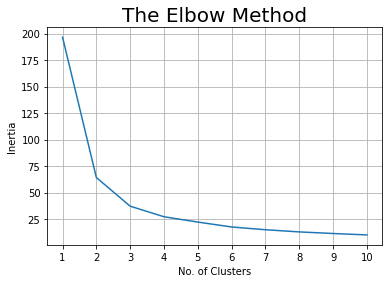

In [ ]:
rf = customer_history_df.iloc[:, [1, 2]].values
ar = customer_history_df.iloc[:, [3, 1]].values
fa = customer_history_df.iloc[:, [2, 3]].values

wcss = []
for i in range(1, 11):
    km = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    km.fit(fa)
    wcss.append(km.inertia_)
    
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method', fontsize = 20)
plt.xlabel('No. of Clusters')
plt.ylabel('Inertia')
plt.xticks(ticks=(1,2,3,4,5,6,7,8,9,10))
plt.grid()
plt.show()

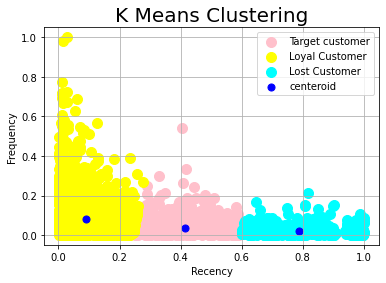

In [ ]:
# model = KMeans(n_clusters=2, init="k-means++",random_state=101)
# model.fit(customer_history_df)
# clusters = model.fit_predict(customer_history_df)
km = KMeans(n_clusters = 3, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
y_means = km.fit_predict(rf)

plt.scatter(rf[y_means == 0, 0], rf[y_means == 0, 1], s = 100, c = 'pink', label = 'Target customer')
plt.scatter(rf[y_means == 1, 0], rf[y_means == 1, 1], s = 100, c = 'yellow', label = 'Loyal Customer')
plt.scatter(rf[y_means == 2, 0], rf[y_means == 2, 1], s = 100, c = 'cyan', label = 'Lost Customer')
plt.scatter(km.cluster_centers_[:,0], km.cluster_centers_[:, 1], s = 50, c = 'blue' , label = 'centeroid')
plt.style.use('seaborn-colorblind')
plt.title('K Means Clustering', fontsize = 20)
plt.xlabel('Recency')
plt.ylabel('Frequency')
plt.legend()
plt.grid()
plt.show()



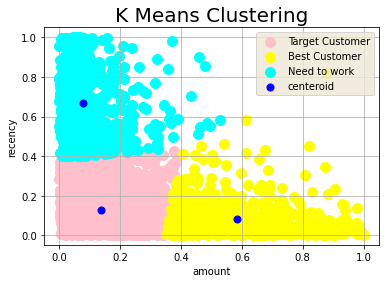

In [ ]:
km = KMeans(n_clusters = 3, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
y_means = km.fit_predict(ar)

plt.scatter(ar[y_means == 0, 0], ar[y_means == 0, 1], s = 100, c = 'pink', label = 'Target Customer')
plt.scatter(ar[y_means == 1, 0], ar[y_means == 1, 1], s = 100, c = 'yellow', label = 'Best Customer')
plt.scatter(ar[y_means == 2, 0], ar[y_means == 2, 1], s = 100, c = 'cyan', label = 'Need to work')
plt.scatter(km.cluster_centers_[:,0], km.cluster_centers_[:, 1], s = 50, c = 'blue' , label = 'centeroid')
plt.style.use('Solarize_Light2')

plt.title('K Means Clustering', fontsize = 20)
plt.xlabel('amount')
plt.ylabel('recency')
plt.legend()
plt.grid()
plt.show()

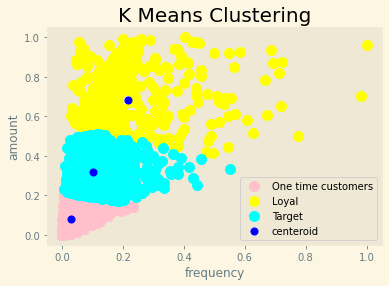

In [ ]:
km = KMeans(n_clusters = 3, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 50)
y_means = km.fit_predict(fa)

plt.scatter(fa[y_means == 0, 0], fa[y_means == 0, 1], s = 100, c = 'pink', label = 'One time customers')
plt.scatter(fa[y_means == 1, 0], fa[y_means == 1, 1], s = 100, c = 'yellow', label = 'Loyal')
plt.scatter(fa[y_means == 2, 0], fa[y_means == 2, 1], s = 100, c = 'cyan', label = 'Target')
plt.scatter(km.cluster_centers_[:,0], km.cluster_centers_[:, 1], s = 50, c = 'blue' , label = 'centeroid')

plt.style.use('seaborn-colorblind')
plt.title('K Means Clustering', fontsize = 20)
plt.xlabel('frequency')
plt.ylabel('amount')
plt.legend()
plt.grid()
plt.show()

#**Apriori Algorithm**

In [ ]:
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1

In [ ]:
dfv

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,amount,year,month,hour,weekday,days_since_last_purchase
0,536365,0,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,2010,12,8,Wednesday,374.0
1,536365,407,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010,12,8,Wednesday,374.0
2,536365,460,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,2010,12,8,Wednesday,374.0
3,536365,281,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010,12,8,Wednesday,374.0
4,536365,274,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010,12,8,Wednesday,374.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
541904,581587,1064,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,10.20,2011,12,12,Friday,1.0
541905,581587,411,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,12.60,2011,12,12,Friday,1.0
541906,581587,361,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60,2011,12,12,Friday,1.0
541907,581587,863,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60,2011,12,12,Friday,1.0


here we are making the dataset suitable for apriori algorithm

In [ ]:
basket = (dfv.groupby(['InvoiceNo', 'Description'])['Quantity'].sum().unstack().reset_index().fillna(0).set_index('InvoiceNo'))
basket

Description,4 PURPLE FLOCK DINNER CANDLES,50'S CHRISTMAS GIFT BAG LARGE,DOLLY GIRL BEAKER,I LOVE LONDON MINI BACKPACK,I LOVE LONDON MINI RUCKSACK,OVAL WALL MIRROR DIAMANTE,RED SPOT GIFT BAG LARGE,SET 2 TEA TOWELS I LOVE LONDON,TRELLIS COAT RACK,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 DAISY PEGS IN WOOD BOX,12 HANGING EGGS HAND PAINTED,12 IVORY ROSE PEG PLACE SETTINGS,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS SMALL TUBE SKULL,12 PENCILS TALL TUBE POSY,12 PENCILS TALL TUBE RED RETROSPOT,12 PENCILS TALL TUBE SKULLS,12 PENCILS TALL TUBE WOODLAND,12 PINK HEN+CHICKS IN BASKET,12 PINK ROSE PEG PLACE SETTINGS,12 RED ROSE PEG PLACE SETTINGS,15 PINK FLUFFY CHICKS IN BOX,15CM CHRISTMAS GLASS BALL 20 LIGHTS,18PC WOODEN CUTLERY SET DISPOSABLE,2 DAISIES HAIR COMB,2 PICTURE BOOK EGGS EASTER BUNNY,2 PICTURE BOOK EGGS EASTER CHICKS,2 PICTURE BOOK EGGS EASTER DUCKS,20 DOLLY PEGS RETROSPOT,200 BENDY SKULL STRAWS,200 RED + WHITE BENDY STRAWS,3 BIRDS CANVAS SCREEN,3 BLACK CATS W HEARTS BLANK CARD,3 DRAWER ANTIQUE WHITE WOOD CABINET,3 GARDENIA MORRIS BOXED CANDLES,3 HEARTS HANGING DECORATION RUSTIC,...,YELLOW COAT RACK PARIS FASHION,YELLOW DRAGONFLY HELICOPTER,YELLOW EASTER EGG HUNT START POST,YELLOW FELT HANGING HEART W FLOWER,YELLOW FLOWERS FELT HANDBAG KIT,YELLOW GIANT GARDEN THERMOMETER,YELLOW METAL CHICKEN HEART,YELLOW PINK FLOWER DESIGN BIG BOWL,YELLOW POT PLANT CANDLE,YELLOW SHARK HELICOPTER,YELLOW/BLUE RETRO RADIO,YELLOW/ORANGE FLOWER DESIGN PLATE,YELLOW/PINK FLOWER DESIGN BIG MUG,YOU'RE CONFUSING ME METAL SIGN,YULETIDE IMAGES GIFT WRAP SET,YULETIDE IMAGES S/6 PAPER BOXES,ZINC HEART T-LIGHT HOLDER,ZINC STAR T-LIGHT HOLDER,ZINC BOX SIGN HOME,ZINC FINISH 15CM PLANTER POTS,ZINC FOLKART SLEIGH BELLS,ZINC HEART FLOWER T-LIGHT HOLDER,ZINC HEART LATTICE 2 WALL PLANTER,ZINC HEART LATTICE CHARGER LARGE,ZINC HEART LATTICE CHARGER SMALL,ZINC HEART LATTICE T-LIGHT HOLDER,ZINC HEART LATTICE TRAY OVAL,ZINC HEARTS PLANT POT HOLDER,ZINC HERB GARDEN CONTAINER,ZINC METAL HEART DECORATION,ZINC PLANT POT HOLDER,ZINC STAR T-LIGHT HOLDER,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
InvoiceNo,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
536365,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536366,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536367,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536368,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536369,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

using the encode function to convert all int values greater than 0 to 1

In [ ]:
basket_sets = basket.applymap(encode_units)

In [ ]:
basket_sets

Description,4 PURPLE FLOCK DINNER CANDLES,50'S CHRISTMAS GIFT BAG LARGE,DOLLY GIRL BEAKER,I LOVE LONDON MINI BACKPACK,I LOVE LONDON MINI RUCKSACK,OVAL WALL MIRROR DIAMANTE,RED SPOT GIFT BAG LARGE,SET 2 TEA TOWELS I LOVE LONDON,TRELLIS COAT RACK,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 DAISY PEGS IN WOOD BOX,12 HANGING EGGS HAND PAINTED,12 IVORY ROSE PEG PLACE SETTINGS,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS SMALL TUBE SKULL,12 PENCILS TALL TUBE POSY,12 PENCILS TALL TUBE RED RETROSPOT,12 PENCILS TALL TUBE SKULLS,12 PENCILS TALL TUBE WOODLAND,12 PINK HEN+CHICKS IN BASKET,12 PINK ROSE PEG PLACE SETTINGS,12 RED ROSE PEG PLACE SETTINGS,15 PINK FLUFFY CHICKS IN BOX,15CM CHRISTMAS GLASS BALL 20 LIGHTS,18PC WOODEN CUTLERY SET DISPOSABLE,2 DAISIES HAIR COMB,2 PICTURE BOOK EGGS EASTER BUNNY,2 PICTURE BOOK EGGS EASTER CHICKS,2 PICTURE BOOK EGGS EASTER DUCKS,20 DOLLY PEGS RETROSPOT,200 BENDY SKULL STRAWS,200 RED + WHITE BENDY STRAWS,3 BIRDS CANVAS SCREEN,3 BLACK CATS W HEARTS BLANK CARD,3 DRAWER ANTIQUE WHITE WOOD CABINET,3 GARDENIA MORRIS BOXED CANDLES,3 HEARTS HANGING DECORATION RUSTIC,...,YELLOW COAT RACK PARIS FASHION,YELLOW DRAGONFLY HELICOPTER,YELLOW EASTER EGG HUNT START POST,YELLOW FELT HANGING HEART W FLOWER,YELLOW FLOWERS FELT HANDBAG KIT,YELLOW GIANT GARDEN THERMOMETER,YELLOW METAL CHICKEN HEART,YELLOW PINK FLOWER DESIGN BIG BOWL,YELLOW POT PLANT CANDLE,YELLOW SHARK HELICOPTER,YELLOW/BLUE RETRO RADIO,YELLOW/ORANGE FLOWER DESIGN PLATE,YELLOW/PINK FLOWER DESIGN BIG MUG,YOU'RE CONFUSING ME METAL SIGN,YULETIDE IMAGES GIFT WRAP SET,YULETIDE IMAGES S/6 PAPER BOXES,ZINC HEART T-LIGHT HOLDER,ZINC STAR T-LIGHT HOLDER,ZINC BOX SIGN HOME,ZINC FINISH 15CM PLANTER POTS,ZINC FOLKART SLEIGH BELLS,ZINC HEART FLOWER T-LIGHT HOLDER,ZINC HEART LATTICE 2 WALL PLANTER,ZINC HEART LATTICE CHARGER LARGE,ZINC HEART LATTICE CHARGER SMALL,ZINC HEART LATTICE T-LIGHT HOLDER,ZINC HEART LATTICE TRAY OVAL,ZINC HEARTS PLANT POT HOLDER,ZINC HERB GARDEN CONTAINER,ZINC METAL HEART DECORATION,ZINC PLANT POT HOLDER,ZINC STAR T-LIGHT HOLDER,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
InvoiceNo,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
536365,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
536366,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
536367,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
536368,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
536369,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581582,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
581583,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
581585,0,0,0,0,0,0,

getting the frequent itemsets

In [ ]:
frequent_itemsets = apriori(basket_sets, min_support=0.01, use_colnames=True)

applying association rules 

In [ ]:
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=0.6)
rules.sort_values('consequent support', ascending=False).reset_index()

,index,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,38,(ASSORTED COLOUR BIRD ORNAMENT),(WHITE HANGING HEART T-LIGHT HOLDER),0.071308,0.108682,0.013993,0.196239,1.805628,0.006244,1.108934
1,147,(HEART OF WICKER LARGE),(WHITE HANGING HEART T-LIGHT HOLDER),0.044662,0.108682,0.016034,0.359008,3.303296,0.011180,1.390529
2,467,(LUNCH BAG SPACEBOY DESIGN ),(WHITE HANGING HEART T-LIGHT HOLDER),0.056207,0.108682,0.010728,0.190871,1.756242,0.004620,1.101578
3,594,(WOODEN FRAME ANTIQUE WHITE ),(WHITE HANGING HEART T-LIGHT HOLDER),0.046295,0.108682,0.014343,0.309824,2.850744,0.009312,1.291436
4,474,(LUNCH BAG SUKI DESIGN ),(WHITE HANGING HEART T-LIGHT HOLDER),0.050784,0.108682,0.010145,0.199770,1.838123,0.004626,1.113828
...,...,...,...,...,...,...,...,...,...,...
935,918,(POPPY'S PLAYHOUSE KITCHEN),"(POPPY'S PLAYHOUSE BEDROOM , POPPY'S PLAYHOUSE...",0.019824,0.011778,0.010495,0.529412,44.950204,0.010262,2.099972
936,544,(REGENCY TEA PLATE ROSES ),(REGENCY TEA PLATE PINK),0.016792,0.011661,0.010029,0.597222,51.214792,0.009833,2.453807
937,540,(REGENCY TEA PLATE GREEN ),(REGENCY TEA PLATE PINK),0.013993,0.011661,0.010378,0.741667,63.601625,0.010215,3.825828
938,153,(HERB MARKER THYME),(HERB MARKER ROSEMARY),0.010670,0.010903,0.010087,0.945355,86.704743,0.009971,18.100472


when we used whole dataset, ignoring the countries, the support values are quite low, lets check if countrywise the support values vary by a lot

In [ ]:
top_5=dfv.groupby('Country')['Quantity'].sum()

In [ ]:
top_5.sort_values(ascending=False).head()

Country
United Kingdom    2377963
Germany             90958
France              81761
EIRE                65079
Switzerland         20847
Name: Quantity, dtype: int64

a function to create encoded dataset suitable to apriori

In [ ]:
def create_basket(country_filter):
    basket = (dfv[dfv['Country'] == country_filter].groupby(['InvoiceNo', 'Description'])['Quantity'].sum().unstack().reset_index().fillna(0).set_index('InvoiceNo'))
    basket_sets = basket.applymap(encode_units)
    return basket_sets

In [ ]:
france=create_basket('France')
f_frequent_itemsets = apriori(france, min_support=0.6, use_colnames=True)
f_rules=association_rules(frequent_itemsets, metric='lift', min_threshold=0.60).sort_values('consequent support', ascending=False)
f_rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
38,(ASSORTED COLOUR BIRD ORNAMENT),(WHITE HANGING HEART T-LIGHT HOLDER),0.071308,0.108682,0.013993,0.196239,1.805628,0.006244,1.108934
147,(HEART OF WICKER LARGE),(WHITE HANGING HEART T-LIGHT HOLDER),0.044662,0.108682,0.016034,0.359008,3.303296,0.011180,1.390529
467,(LUNCH BAG SPACEBOY DESIGN ),(WHITE HANGING HEART T-LIGHT HOLDER),0.056207,0.108682,0.010728,0.190871,1.756242,0.004620,1.101578
594,(WOODEN FRAME ANTIQUE WHITE ),(WHITE HANGING HEART T-LIGHT HOLDER),0.046295,0.108682,0.014343,0.309824,2.850744,0.009312,1.291436
474,(LUNCH BAG SUKI DESIGN ),(WHITE HANGING HEART T-LIGHT HOLDER),0.050784,0.108682,0.010145,0.199770,1.838123,0.004626,1.113828
...,...,...,...,...,...,...,...,...,...
918,(POPPY'S PLAYHOUSE KITCHEN),"(POPPY'S PLAYHOUSE BEDROOM , POPPY'S PLAYHOUSE...",0.019824,0.011778,0.010495,0.529412,44.950204,0.010262,2.099972
544,(REGENCY TEA PLATE ROSES ),(REGENCY TEA PLATE PINK),0.016792,0.011661,0.010029,0.597222,51.214792,0.009833,2.453807
540,(REGENCY TEA PLATE GREEN ),(REGENCY TEA PLATE PINK),0.013993,0.011661,0.010378,0.741667,63.601625,0.010215,3.825828
153,(HERB MARKER THYME),(HERB MARKER ROSEMARY),0.010670,0.010903,0.010087,0.945355,86.704743,0.009971,18.100472


In [ ]:
germany=create_basket('Germany')
g_frequent_itemsets = apriori(germany, min_support=0.6, use_colnames=True)
g_rules=association_rules(frequent_itemsets, metric='lift', min_threshold=0.60).sort_values('consequent support', ascending=False)
g_rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
38,(ASSORTED COLOUR BIRD ORNAMENT),(WHITE HANGING HEART T-LIGHT HOLDER),0.071308,0.108682,0.013993,0.196239,1.805628,0.006244,1.108934
147,(HEART OF WICKER LARGE),(WHITE HANGING HEART T-LIGHT HOLDER),0.044662,0.108682,0.016034,0.359008,3.303296,0.011180,1.390529
467,(LUNCH BAG SPACEBOY DESIGN ),(WHITE HANGING HEART T-LIGHT HOLDER),0.056207,0.108682,0.010728,0.190871,1.756242,0.004620,1.101578
594,(WOODEN FRAME ANTIQUE WHITE ),(WHITE HANGING HEART T-LIGHT HOLDER),0.046295,0.108682,0.014343,0.309824,2.850744,0.009312,1.291436
474,(LUNCH BAG SUKI DESIGN ),(WHITE HANGING HEART T-LIGHT HOLDER),0.050784,0.108682,0.010145,0.199770,1.838123,0.004626,1.113828
...,...,...,...,...,...,...,...,...,...
918,(POPPY'S PLAYHOUSE KITCHEN),"(POPPY'S PLAYHOUSE BEDROOM , POPPY'S PLAYHOUSE...",0.019824,0.011778,0.010495,0.529412,44.950204,0.010262,2.099972
544,(REGENCY TEA PLATE ROSES ),(REGENCY TEA PLATE PINK),0.016792,0.011661,0.010029,0.597222,51.214792,0.009833,2.453807
540,(REGENCY TEA PLATE GREEN ),(REGENCY TEA PLATE PINK),0.013993,0.011661,0.010378,0.741667,63.601625,0.010215,3.825828
153,(HERB MARKER THYME),(HERB MARKER ROSEMARY),0.010670,0.010903,0.010087,0.945355,86.704743,0.009971,18.100472


In [ ]:
uk=create_basket('United Kingdom ')
uk_frequent_itemsets = apriori(uk, min_support=0.6, use_colnames=True)
uk_rules=association_rules(frequent_itemsets, metric='lift', min_threshold=0.60).sort_values('consequent support', ascending=False)
uk_rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
38,(ASSORTED COLOUR BIRD ORNAMENT),(WHITE HANGING HEART T-LIGHT HOLDER),0.071308,0.108682,0.013993,0.196239,1.805628,0.006244,1.108934
147,(HEART OF WICKER LARGE),(WHITE HANGING HEART T-LIGHT HOLDER),0.044662,0.108682,0.016034,0.359008,3.303296,0.011180,1.390529
467,(LUNCH BAG SPACEBOY DESIGN ),(WHITE HANGING HEART T-LIGHT HOLDER),0.056207,0.108682,0.010728,0.190871,1.756242,0.004620,1.101578
594,(WOODEN FRAME ANTIQUE WHITE ),(WHITE HANGING HEART T-LIGHT HOLDER),0.046295,0.108682,0.014343,0.309824,2.850744,0.009312,1.291436
474,(LUNCH BAG SUKI DESIGN ),(WHITE HANGING HEART T-LIGHT HOLDER),0.050784,0.108682,0.010145,0.199770,1.838123,0.004626,1.113828
...,...,...,...,...,...,...,...,...,...
918,(POPPY'S PLAYHOUSE KITCHEN),"(POPPY'S PLAYHOUSE BEDROOM , POPPY'S PLAYHOUSE...",0.019824,0.011778,0.010495,0.529412,44.950204,0.010262,2.099972
544,(REGENCY TEA PLATE ROSES ),(REGENCY TEA PLATE PINK),0.016792,0.011661,0.010029,0.597222,51.214792,0.009833,2.453807
540,(REGENCY TEA PLATE GREEN ),(REGENCY TEA PLATE PINK),0.013993,0.011661,0.010378,0.741667,63.601625,0.010215,3.825828
153,(HERB MARKER THYME),(HERB MARKER ROSEMARY),0.010670,0.010903,0.010087,0.945355,86.704743,0.009971,18.100472


In [ ]:
s=create_basket('Switzerland')
s_frequent_itemsets = apriori(s, min_support=0.6, use_colnames=True)
s_rules=association_rules(frequent_itemsets, metric='lift', min_threshold=0.60).sort_values('consequent support', ascending=False)
s_rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
38,(ASSORTED COLOUR BIRD ORNAMENT),(WHITE HANGING HEART T-LIGHT HOLDER),0.071308,0.108682,0.013993,0.196239,1.805628,0.006244,1.108934
147,(HEART OF WICKER LARGE),(WHITE HANGING HEART T-LIGHT HOLDER),0.044662,0.108682,0.016034,0.359008,3.303296,0.011180,1.390529
467,(LUNCH BAG SPACEBOY DESIGN ),(WHITE HANGING HEART T-LIGHT HOLDER),0.056207,0.108682,0.010728,0.190871,1.756242,0.004620,1.101578
594,(WOODEN FRAME ANTIQUE WHITE ),(WHITE HANGING HEART T-LIGHT HOLDER),0.046295,0.108682,0.014343,0.309824,2.850744,0.009312,1.291436
474,(LUNCH BAG SUKI DESIGN ),(WHITE HANGING HEART T-LIGHT HOLDER),0.050784,0.108682,0.010145,0.199770,1.838123,0.004626,1.113828
...,...,...,...,...,...,...,...,...,...
918,(POPPY'S PLAYHOUSE KITCHEN),"(POPPY'S PLAYHOUSE BEDROOM , POPPY'S PLAYHOUSE...",0.019824,0.011778,0.010495,0.529412,44.950204,0.010262,2.099972
544,(REGENCY TEA PLATE ROSES ),(REGENCY TEA PLATE PINK),0.016792,0.011661,0.010029,0.597222,51.214792,0.009833,2.453807
540,(REGENCY TEA PLATE GREEN ),(REGENCY TEA PLATE PINK),0.013993,0.011661,0.010378,0.741667,63.601625,0.010215,3.825828
153,(HERB MARKER THYME),(HERB MARKER ROSEMARY),0.010670,0.010903,0.010087,0.945355,86.704743,0.009971,18.100472


In [ ]:
eire=create_basket('EIRE')
eire_frequent_itemsets = apriori(eire, min_support=0.6, use_colnames=True)
eire_rules=association_rules(frequent_itemsets, metric='lift', min_threshold=0.60).sort_values('consequent support', ascending=False)
eire_rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
38,(ASSORTED COLOUR BIRD ORNAMENT),(WHITE HANGING HEART T-LIGHT HOLDER),0.071308,0.108682,0.013993,0.196239,1.805628,0.006244,1.108934
147,(HEART OF WICKER LARGE),(WHITE HANGING HEART T-LIGHT HOLDER),0.044662,0.108682,0.016034,0.359008,3.303296,0.011180,1.390529
467,(LUNCH BAG SPACEBOY DESIGN ),(WHITE HANGING HEART T-LIGHT HOLDER),0.056207,0.108682,0.010728,0.190871,1.756242,0.004620,1.101578
594,(WOODEN FRAME ANTIQUE WHITE ),(WHITE HANGING HEART T-LIGHT HOLDER),0.046295,0.108682,0.014343,0.309824,2.850744,0.009312,1.291436
474,(LUNCH BAG SUKI DESIGN ),(WHITE HANGING HEART T-LIGHT HOLDER),0.050784,0.108682,0.010145,0.199770,1.838123,0.004626,1.113828
...,...,...,...,...,...,...,...,...,...
918,(POPPY'S PLAYHOUSE KITCHEN),"(POPPY'S PLAYHOUSE BEDROOM , POPPY'S PLAYHOUSE...",0.019824,0.011778,0.010495,0.529412,44.950204,0.010262,2.099972
544,(REGENCY TEA PLATE ROSES ),(REGENCY TEA PLATE PINK),0.016792,0.011661,0.010029,0.597222,51.214792,0.009833,2.453807
540,(REGENCY TEA PLATE GREEN ),(REGENCY TEA PLATE PINK),0.013993,0.011661,0.010378,0.741667,63.601625,0.010215,3.825828
153,(HERB MARKER THYME),(HERB MARKER ROSEMARY),0.010670,0.010903,0.010087,0.945355,86.704743,0.009971,18.100472
